## Note

This notebook assumes familiarity with the `numpy` and `pandas` libraries. If you are not familiar with these libraries, you can find a notebook introducing them [here](https://drive.google.com/file/d/1VhK6F1j0jvTbWTSu4cLx_aHrl6B3mWt7/view?usp=drive_link) and the corresponding lecture (given for the Neural Networks course) [here](https://unito.webex.com/recordingservice/sites/unito/recording/7c137497f8164bb1bfd6097feab48299/playback).

## Exercise 1: Exploring Overfitting and Underfitting (Scikit-learn, Numpy, Matplotlib)

This exercise is based on the discussion of *overfitting* and *underfitting* in `02-ModelSelection.pdf`. You will visualize how model complexity affects performance on training and validation data.

**Goal:** See the bias-variance trade-off in action.

**Tasks:**
1.  Generate a synthetic dataset. Create a 1D non-linear function (e.g., `y = sin(x)`) and add some random noise to the `y` values.
2.  Split your data into a training set and a test set using `sklearn.model_selection.train_test_split`.
3.  Create a loop that fits polynomial regression models of increasing complexity (from degree 1 to 20).
    *   Inside the loop, use `sklearn.preprocessing.PolynomialFeatures` to create polynomial features, followed by `sklearn.linear_model.LinearRegression`.
4.  For each degree:
    *   Train the model on the training data.
    *   Calculate and store the Mean Squared Error (MSE) on both the **training set** and the **test set**.
5.  Plot the training MSE and test MSE as a function of the polynomial degree. You should see the training error continuously decrease and the test error decrease initially and then start increasing (forming a U-shape).
6.  Identify the approximate polynomial degree that represents a good trade-off (the "sweet spot" before overfitting begins).

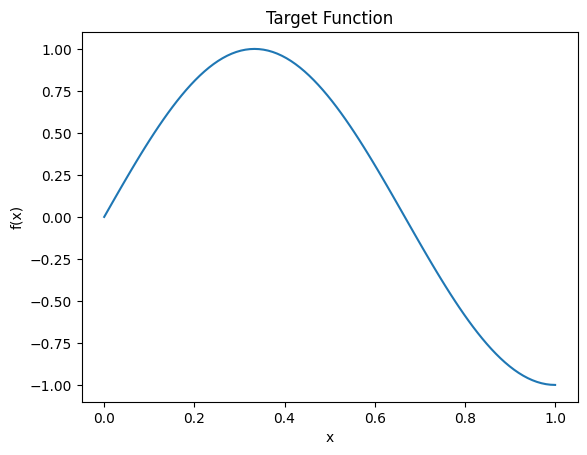

In [2]:
import numpy as np

def target_function(x):
    return np.sin(1.5 * np.pi * x)

import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)
y = target_function(x)
plt.plot(x, y)
plt.title("Target Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


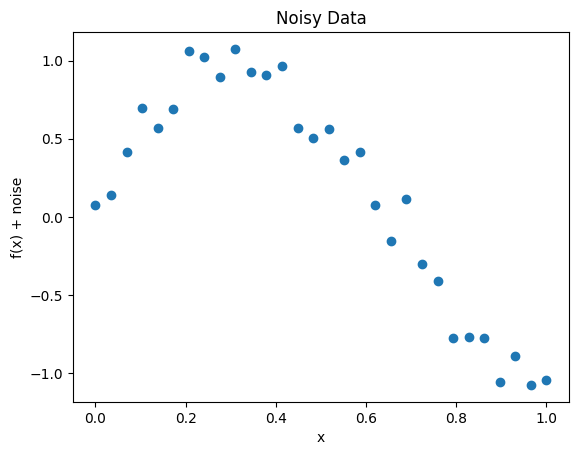

In [7]:
noise_std = 0.15

# add random gaussian noise to the target function
X = np.linspace(0, 1, 30).reshape(-1, 1)
np.random.seed(42)
y = target_function(X) + np.random.normal(0, noise_std, X.shape)
plt.scatter(X, y)
plt.title("Noisy Data")
plt.xlabel("x")
plt.ylabel("f(x) + noise")
plt.show()

In [8]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

Text(0, 0.5, 'f(x) + noise')

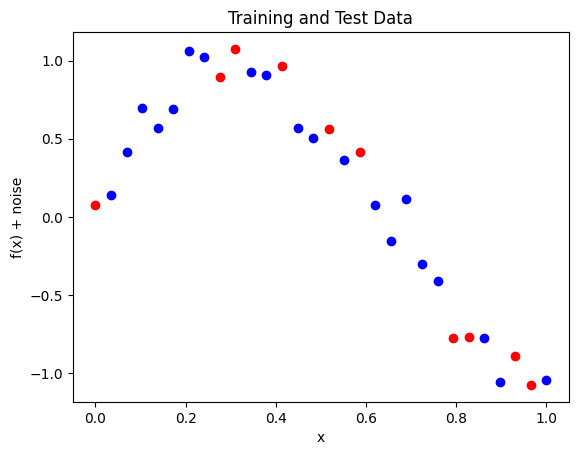

In [9]:
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='red', label='Test Data')
plt.title("Training and Test Data")
plt.xlabel("x")
plt.ylabel("f(x) + noise")

In [18]:
class LeastSquares:
    def __init__(self):
        self._coef = None

    # w = (X^T X)^(-1) X^T y
    def fit(self, X, y):
        self._coef = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        return X @ self._coef

#### Plotting fitted models and data

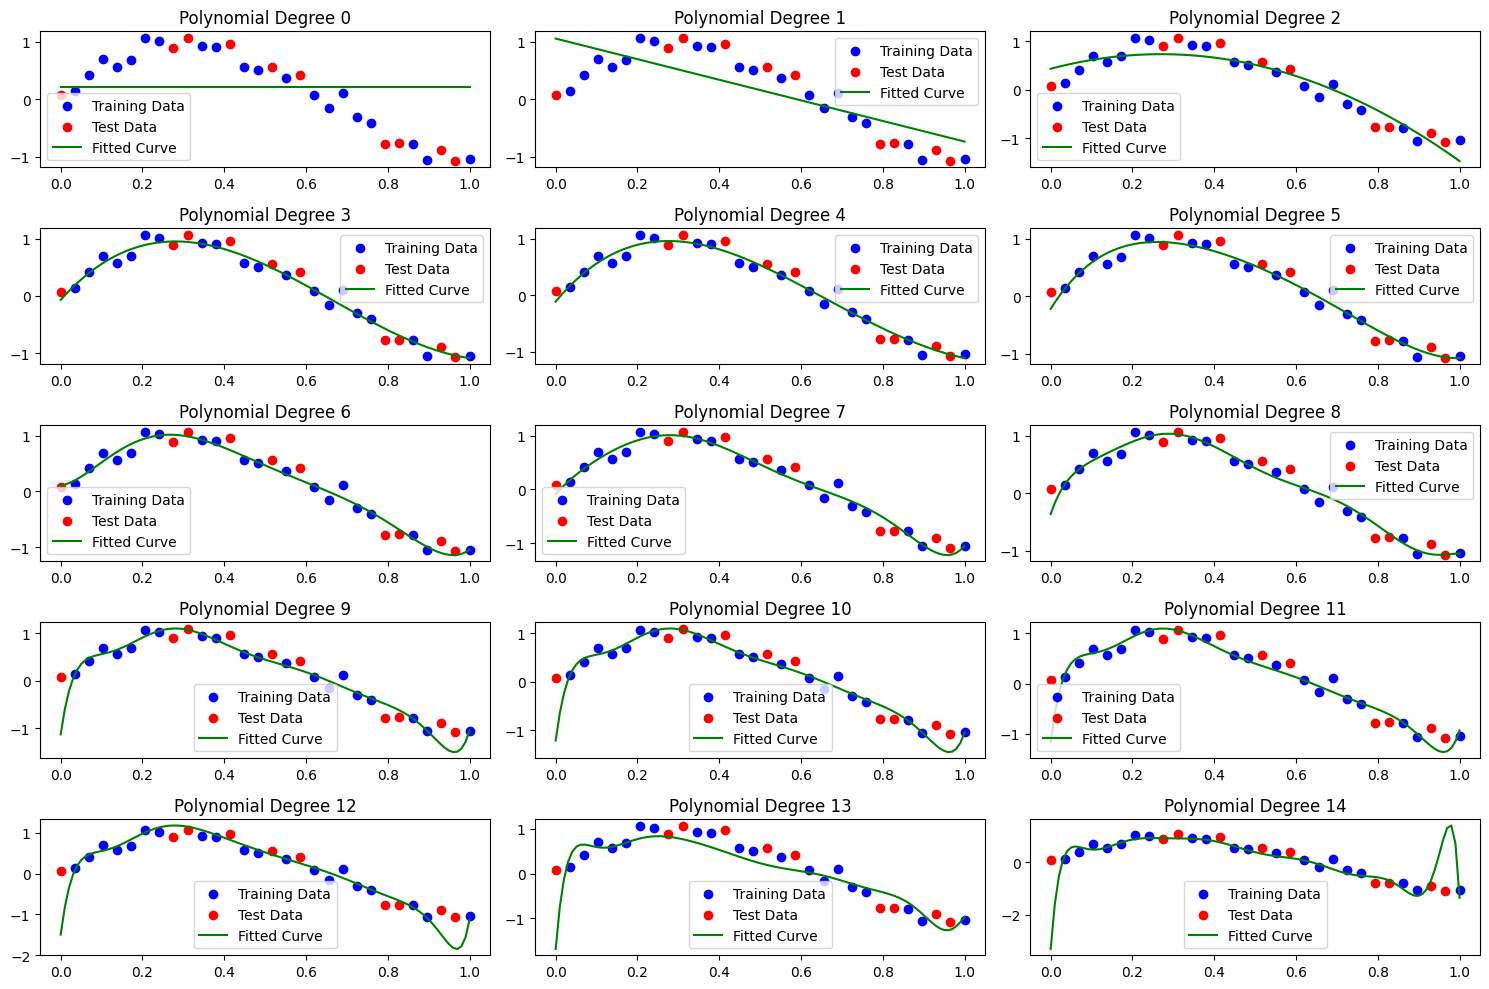

In [19]:
from sklearn.metrics import mean_squared_error

train_errors = []
test_errors = []

fig, axes = plt.subplots(5, 3, figsize=(15, 10))
axes = axes.ravel()

for degree in range(15):
    model = LeastSquares()
    poly_features = sklearn.preprocessing.PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    model.fit(X_train_poly, y_train)
    train_errors.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_errors.append(mean_squared_error(y_test, model.predict(poly_features.transform(X_test))))

    x_fit = np.linspace(0, 1, 100).reshape(-1, 1)
    y_fit = model.predict(poly_features.transform(x_fit))   
    axes[degree].scatter(X_train, y_train, color='blue', label='Training Data')
    axes[degree].scatter(X_test, y_test, color='red', label='Test Data')
    axes[degree].plot(x_fit, y_fit, color='green', label='Fitted Curve')
    axes[degree].set_title(f'Polynomial Degree {degree}')
    axes[degree].legend()   

plt.tight_layout()
plt.show()

#### Plotting train /test errors as a function of model complexity

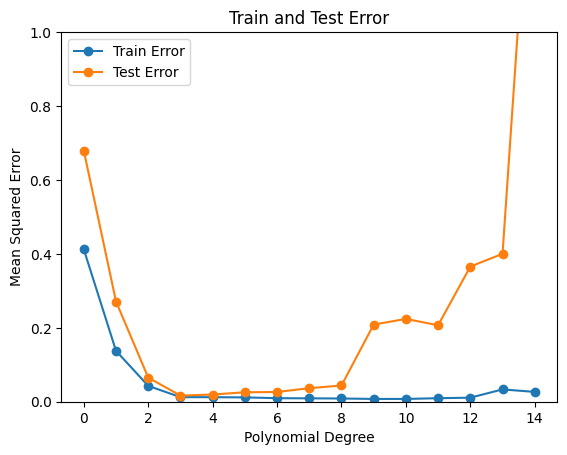

In [20]:
plt.plot(train_errors, label='Train Error', marker='o')
plt.plot(test_errors, label='Test Error', marker='o')
plt.title("Train and Test Error")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.ylim(0, 1)
plt.legend()
plt.show()

### Exercise 2: Model Selection and Hyperparameter Tuning (Scikit-learn)

This exercise combines several topics from `02-ModelSelection.pdf`, including *cross-validation*, *performance metrics*, and *parameter tuning*.

**Goal:** Compare different classifiers and find the best hyperparameters for a given model using a robust evaluation strategy.

**Dataset:** Use a real-world dataset from scikit-learn: the Breast Cancer dataset (`sklearn.datasets.load_breast_cancer`).

**Tasks:**
1.  Load the dataset and split it into a training set (80%) and a final test set (20%). You will not touch the test set until the very end.
2.  Choose two three different classification algorithms (`KNeighborsClassifier`, `SVC`, and `LogisticRegression`).
3.  Use `sklearn.model_selection.GridSearchCV` with 5-fold cross-validation on the **training set** to find the best hyperparameters for `SVC` and `KNeighborsClassifier`.
    *   For `SVC`, tune the `C` and `gamma` parameters.
    *   For `KNeighborsClassifier`, tune the `n_neighbors` parameter.
    *   For `LogisticRegression`, tune the `C` parameter (analogous to regularizing as it is done for Ridge regression).
4.  For each of your tuned models,  report the best cross-validated score on the training data (ideally you might want to explore more than one metric, start with the `accuracy` metric). 
5.  Select the single best model/hyperparameter combination based on your cross-validation results.
6. Report the accuracy of the models also on the test set, and compare it with the cross-validated accuracy. 

In [24]:
import sklearn.datasets
import sklearn.model_selection
import sklearn.svm
import sklearn.neighbors
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt

digits = sklearn.datasets.load_breast_cancer()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.33, random_state=42
)

C_values = [0.1, 1, 10, 100]
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1]
K_values = [1, 3, 5, 7]

# performs the grid search with cross-validation
# results format: (Learning Algorithm Name, C, gamma, K, cv accuracy, test set accuracy)
results = []
for C in C_values:
    for gamma in gamma_values:
        svm_model = sklearn.svm.SVC(C=C, gamma=gamma)
        cv_scores = sklearn.model_selection.cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
        
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        test_set_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

        results.append(('SVC', C, gamma, None, np.mean(cv_scores), test_set_accuracy))

for K in K_values:
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=K)
    cv_scores = sklearn.model_selection.cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    test_set_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

    results.append(('KNN', None, None, K, np.mean(cv_scores), test_set_accuracy))

for C in C_values:
    logreg_model = sklearn.linear_model.LogisticRegression(C=C, max_iter=1000)
    cv_scores = sklearn.model_selection.cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')

    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)
    test_set_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

    results.append(('LogReg', C, None, None, np.mean(cv_scores), test_set_accuracy))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [27]:
import pandas as pd
df_results = pd.DataFrame(results, columns=['Model', 'C', 'Gamma', 'K', 'CV Accuracy', 'Test Set Accuracy'])
df_results.sort_values(by='CV Accuracy', ascending=False, inplace=True)
df_results

,Model,C,Gamma,K,CV Accuracy,Test Set Accuracy
27,LogReg,100.0,NaN,NaN,0.963226,0.962766
26,LogReg,10.0,NaN,NaN,0.952700,0.957447
25,LogReg,1.0,NaN,NaN,0.937047,0.957447
24,LogReg,0.1,NaN,NaN,0.937013,0.957447
10,SVC,10.0,0.0001,NaN,0.936910,0.962766
15,SVC,100.0,0.0001,NaN,0.934211,0.941489
5,SVC,1.0,0.0001,NaN,0.923855,0.968085
22,KNN,NaN,NaN,5.0,0.918626,0.952128
23,KNN,NaN,NaN,7.0,0.913363,0.973404
6,SVC,1.0,0.0010,NaN,0.913329,0.920213
